# Trabajo Practico Numero 2 
## Analisis inteligente de jugadores de un reconocido juego electronico
### Mentorias. Grupo 16

Integrantes:

-Juan Cruz Bordón

-Nicolás Ambrosis

-Laura A. Feü


In [60]:
# Cargamos la librerias
import numpy as np
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats.mstats import mode
from statistics import mode
pd.set_option('display.float_format', '{:,.2f}'.format)
import seaborn as sns
sns.set_context('talk')
import missingno as msno
import re
import unidecode

In [61]:
# Cargamos el dataset 
df = pd.read_csv('datos_jugadores.csv')

### Seccion 1: Identificacion

### 1. Identificar los nan y resolverlos

In [62]:
# Chequeamos que columnas tienen valores nans y cuantos tiene
print(df.isna().sum())

id                 0
datetime           0
has_studies    56878
gender         39077
country        39077
state          59086
age            39077
cups               0
dtype: int64


<AxesSubplot:>

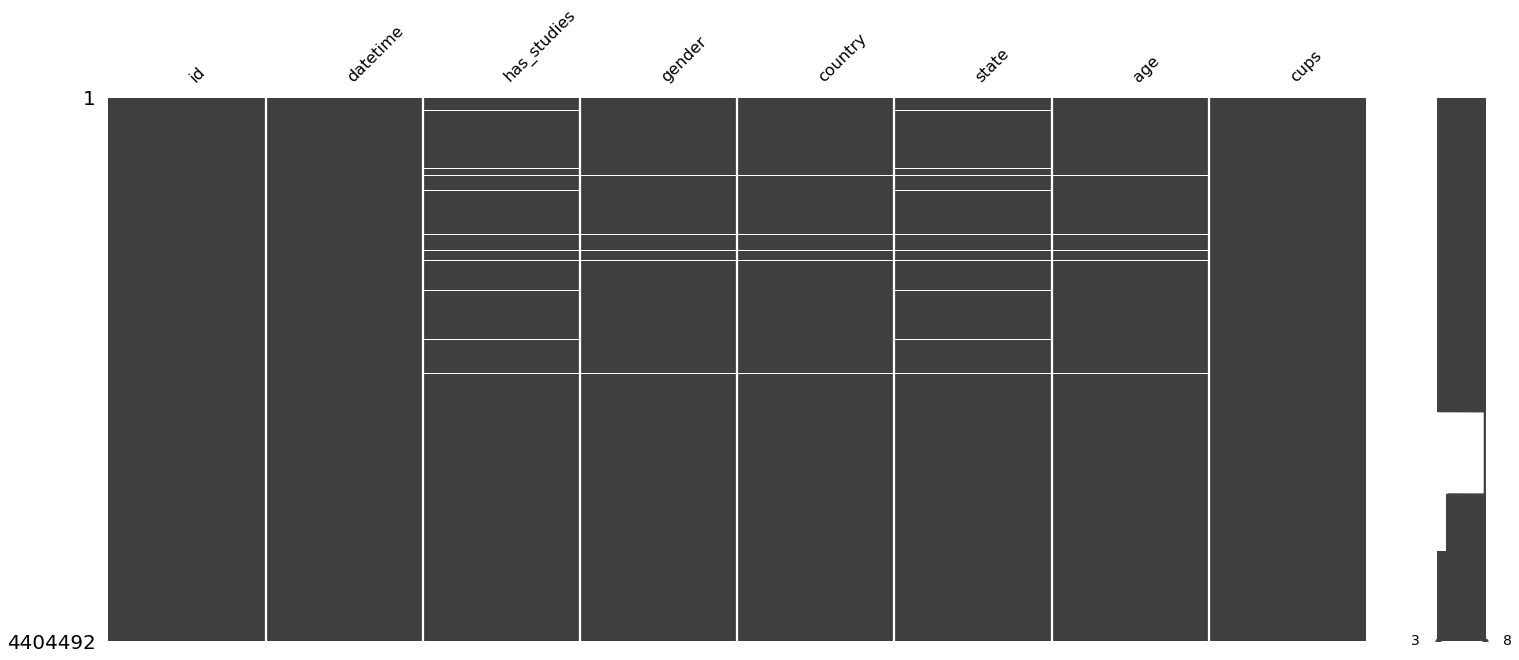

In [63]:
# Con la libreria missingno vamos a analizar la distribucion de nans en el dataset
msno.matrix(df)

Esta visualizacion parece sugerir que existe un patron definido en grupos de datos faltantes. Al ejecutar sucesivas veces la celda anterior vemos que en muchos casos faltan datos en las columnas has_studies, gender, country, state y age. Para confirmar esta hipotesis podemos utilizar la visualizacion tipo matriz del paquete missingno.  

<AxesSubplot:>

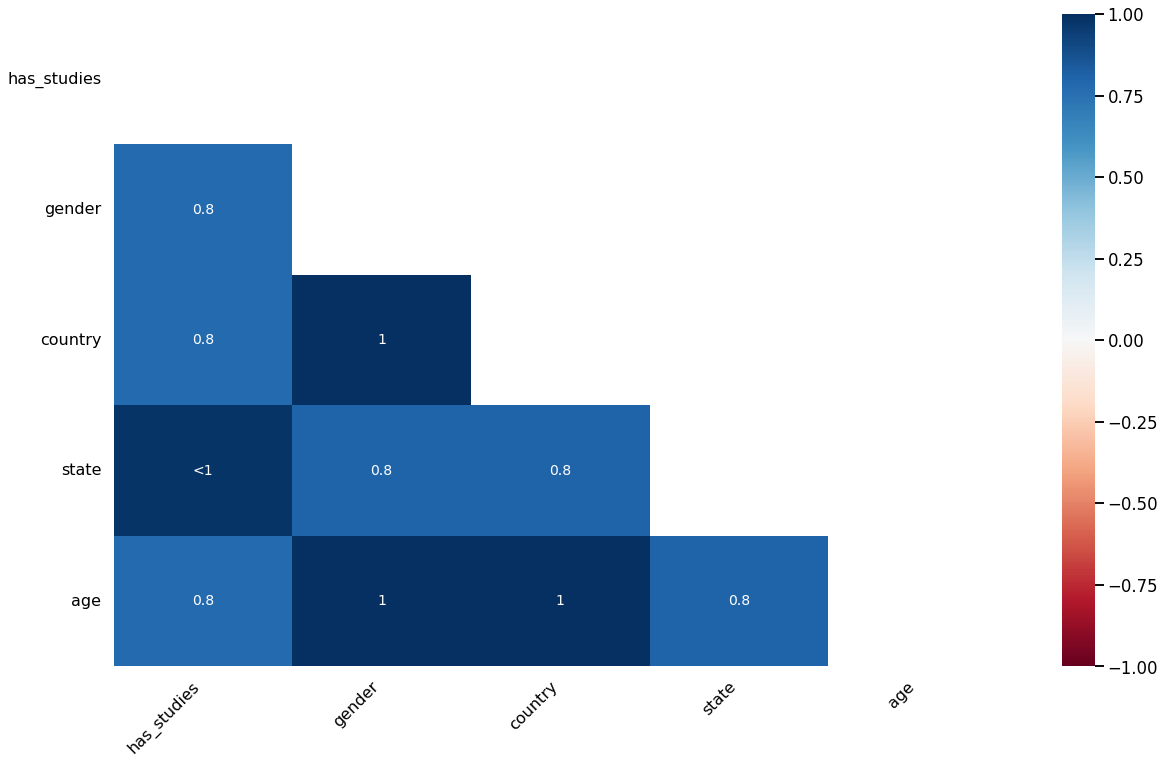

In [64]:
msno.heatmap(df)

Este resultado muestra que existe una correlacion positiva muy fuerte entre los datos faltante. Es resultado sugiere que la perdida de datos no es aleatoria. Podria ser que algunos usuarios en particular no hubieran querido completar los datos solicitados por el sistema

---

In [65]:
# Calculamos la cantidad de jugadores que tienen datos faltantes
df[df.isna().sum(axis = 1) != 0].id.nunique()

9

Sola hay 9 jugadores que tienen features faltantes

In [66]:
#Cuantos jugadores representan del total
print(((df[df.isna().sum(axis = 1) != 0].id.nunique())/df.id.nunique())*100)


0.6254343293954135


In [67]:
# Cuantas entradas representa del total
print((len(df[df.isna().sum(axis = 1) != 0])/len(df))*100)

1.3414940928488461


Podemos ver que no representan ni un gran porcentaje de los jugadores totales, ni tampoco de las entratadas totales

In [68]:
ids_with_less_features = df[df.isna().sum(axis = 1) != 0].id.unique()
for id in ids_with_less_features:
    print(id)
    print(df[df.id == id].isna().sum())
    print("Entradas del id:", len(df[df.id == id]))
    print("-----")

4ec9599fc203d176a301536c2e091a19bc852759b255bd6818810a42c5fed14a
id                 0
datetime           0
has_studies    10744
gender             0
country            0
state          10744
age                0
cups               0
dtype: int64
Entradas del id: 10744
-----
e629fa6598d732768f7c726b4b621285f9c3b85303900aa912017db7617d8bdb
id                0
datetime          0
has_studies    9265
gender            0
country           0
state          9265
age               0
cups              0
dtype: int64
Entradas del id: 9265
-----
7688b6ef52555962d008fff894223582c484517cea7da49ee67800adc7fc8866
id                 0
datetime           0
has_studies    12011
gender         12011
country        12011
state          12011
age            12011
cups               0
dtype: int64
Entradas del id: 12011
-----
8241649609f88ccd2a0a5b233a07a538ec313ff6adf695aa44a969dbca39f67d
id                 0
datetime           0
has_studies    11093
gender         11093
country        11093
state         

Podemos ver que para todos los ids en todas sus entradas faltan los mismos features. Considerando que es poco el porcentaje de data que se pierde y que no hay forma de obtener esa data de otra entra se decide descartar las entradas con features nulos.

In [69]:
df_drop = df.dropna()

### 2. Identificar las fechas de nacimiento mal escritas.

In [70]:
df_drop.age.unique()


array([1997., 1999., 2003., 2000., 2001., 1996., 1998., 1995., 1994.,
       1990., 1993., 2002., 1991.,   91., 1986., 1989., 2005., 1992.,
         97., 1973., 1980., 2021., 1985., 2004., 1987., 1979., 1983.,
       1981., 1982., 1966., 1968., 1972., 1988., 1961., 1984., 1977.,
          3., 1978., 1967.,   99.,  200., 1974., 1963., 1959., 1975.,
       1976., 1970., 2009., 2022.])

Cualquier fecha año que tenga menos de 4 digitos o si es de hace menos de 10 años no es valida

### 3. Identificar los países mal escritos.

In [71]:
df_drop.country.unique()


array(['Argentina', 'Venezuela', 'Perú', 'Philippines', 'Ecuador',
       'Chile', 'España', 'México', 'Cuba', 'Colombia', 'Uruguay',
       'Bolivia', 'venezuela', 'De Venezuela', 'argentina',
       'Venezuela - Maracaibo', 'Costa Rica', 'ARGENTINA', 'colombia',
       'Venenezuela', 'Argentino'], dtype=object)

Los paises mal escritos son argentina, Argentina, argentino, venezuela, De Venezuela, Venezuela - Maracaibo, colombia, Venenezuela

### 4. Identificar los estados mal escritos.

In [72]:
np.sort(df_drop.state.unique())


array(['Alajuela', 'Amazonas', 'Andalucía', 'Andes', 'Anzoategui',
       'Anzoatequi', 'Anzoátegui', 'Anzuategui', 'Apure', 'Aragua',
       'Aragua - región central', 'Atlántico', 'BUENOS AIRES',
       'Barcelona', 'Barinas', 'Barquisimeto', 'Bio Bio', 'Bogota',
       'Bogotá D.C', 'Bolivar', 'Bs as', 'Bs.as', 'Buenas Aires',
       'Bueno Aires', 'Buenoas Aires', 'Buenos Aires', 'Buenos aires',
       'Burnos Aires', 'C.A.B.A', 'CABA', 'CARACAS', 'Caba', 'Cagua',
       'Camarines Sur', 'Camarines sur', 'Camarines sur naga city',
       'Camarinesur', 'Canelones', 'Capital', 'Capital Federal',
       'Carabobo', 'Carabobo valencia', 'Caraca', 'Caracas', 'Cartago',
       'Catamarca', 'Catia la mar', 'Centro occidente', 'Chaco',
       'Charallave', 'Chiclayo', 'Chubut',
       'Ciudad Autónoma de Buenos Aires',
       'Ciudad autónoma de Buenos Aires', 'Ciudad de Buenos Aires',
       'Ciudad de Buenos aires', 'Cojedes', 'Cordoba', 'Coro',
       'Corrientes', 'Cundinamarca', 'Cór

### Sección 2: Curación

### 1. Corregir las fechas de nacimiento mal escritos.

In [73]:
df_drop.rename(columns = {'age': 'birth'}, inplace = True)
print(df_drop.birth.unique())
replacement_mapping_dict = {3:2003, 91:1991, 97:1997, 99:1999, 200:2000}
df_drop.birth.replace(replacement_mapping_dict, inplace = True)
df_drop.birth.unique()
df_drop[df_drop.birth > 2012].id.nunique()
len(df_drop[df_drop.birth > 2012])


[1997. 1999. 2003. 2000. 2001. 1996. 1998. 1995. 1994. 1990. 1993. 2002.
 1991.   91. 1986. 1989. 2005. 1992.   97. 1973. 1980. 2021. 1985. 2004.
 1987. 1979. 1983. 1981. 1982. 1966. 1968. 1972. 1988. 1961. 1984. 1977.
    3. 1978. 1967.   99.  200. 1974. 1963. 1959. 1975. 1976. 1970. 2009.
 2022.]


6868

In [74]:
# Analizamos las edades invalidas
print("Hay {} jugadores con edad invalida".format(df_drop[df_drop.birth > 2012].id.nunique()))
print("Representan en total {} entradas".format(len(df_drop[df_drop.birth > 2012])))
print("Porcentaje de jugadores del total:", (df_drop[df_drop.birth > 2012].id.nunique()/df.id.nunique())*100)
print("Porcentaje de entradas del total:", (len(df_drop[df_drop.birth > 2012])/len(df.id))*100)

Hay 5 jugadores con edad invalida
Representan en total 6868 entradas
Porcentaje de jugadores del total: 0.34746351633078526
Porcentaje de entradas del total: 0.1559317169834796


Como representan una poca cantidad de entradas y de jugadores se elige descartarlas.

In [75]:
df_drop = df_drop.drop(df_drop[df_drop.birth > 2012].index)

### 2.  Corregir los nombres de los países mal escritos.

In [76]:
# Normalizamos los nombres pasandolos a minuscula y luego pasando la primera letra a mayuscula
print(df_drop.country.unique())
for i in df_drop.country.unique():
    if i.islower():
        bad_name = i
        new_name = i.title()
        print("bad name:", bad_name, "new name", new_name)
        df_drop.loc[df_drop.country == bad_name, "country"] = new_name
    elif i.isupper():
        bad_name = i
        i = i.lower()
        new_name = i.title()
        print("bad name:", bad_name, "new name", new_name)
        df_drop.loc[df_drop.country == bad_name, "country"] = new_name
replacement_mapping_dict = {'De Venezuela':'Venezuela', 'Venezuela - Maracaibo':'Venezuela', 'Venenezuela':'Venezuela', 'Argentino':'Argentina'}
df_drop.country.replace(replacement_mapping_dict, inplace = True)
df_drop.country.unique()


['Argentina' 'Venezuela' 'Perú' 'Philippines' 'Ecuador' 'Chile' 'España'
 'México' 'Cuba' 'Colombia' 'Uruguay' 'Bolivia' 'venezuela' 'De Venezuela'
 'argentina' 'Venezuela - Maracaibo' 'Costa Rica' 'ARGENTINA' 'colombia'
 'Venenezuela' 'Argentino']
bad name: venezuela new name Venezuela
bad name: argentina new name Argentina
bad name: ARGENTINA new name Argentina
bad name: colombia new name Colombia


array(['Argentina', 'Venezuela', 'Perú', 'Philippines', 'Ecuador',
       'Chile', 'España', 'México', 'Cuba', 'Colombia', 'Uruguay',
       'Bolivia', 'Costa Rica'], dtype=object)

### 3.  Corregir los nombres de los estados mal escritos. Priorizar los de Argentina y Venezuela.

In [77]:
# ARGENTINA
unique_list = df_drop[df_drop.country == 'Argentina'].state.unique()
print(unique_list)
for i in unique_list:
    if i != unidecode.unidecode(i.lower().title()):
        bad_name = i
        new_name = unidecode.unidecode(i.lower().title())
        print("bad name:", bad_name, "new name", new_name)
        df_drop.loc[df_drop.state == bad_name, "state"] = new_name
df_drop.loc[df_drop.state == "Santa Fa", "state"] = "Santa Fe"
df_drop.loc[df_drop.state == "Santafe", "state"] = "Santa Fe"
df_drop.loc[df_drop.state == "C.A.B.A", "state"] = "Ciudad Autonoma De Buenos Aires"
df_drop.loc[df_drop.state == "Caba", "state"] = "Ciudad Autonoma De Buenos Aires"
df_drop.loc[df_drop.state == "Capital Federal", "state"] = "Ciudad Autonoma De Buenos Aires"
df_drop.loc[df_drop.state == "Ciudad De Buenos Aires", "state"] = "Ciudad Autonoma De Buenos Aires"
df_drop.loc[df_drop.state == "Tigre", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Pilar", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Buenoas Aires", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Buenos Aries", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Bs.As", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Burnos Aires", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Buenas Aires", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Bs As", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Bueno Aires", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Mar Del Plata", "state"] = "Buenos Aires"
df_drop.loc[df_drop.state == "Salta Capital", "state"] = "Salta"
df_drop.loc[df_drop.state == "Santaigo Del Estero", "state"] = "Santiago Del Estero"
df_drop.loc[df_drop.state == "San Salvador De Jujuy", "state"] = "Jujuy"


unique_list = df_drop[df_drop.country == 'Argentina'].state.unique()
print(unique_list)

['Santa Fe' 'Santa fe' 'Entre Rios' 'Cordoba' 'Buenos Aires' 'C.A.B.A'
 'Entre Ríos' 'Entre rios' 'Buenos aires' 'CABA' 'Córdoba' 'la Rioja'
 'santa fe' 'Bueno Aires' 'Santafe' 'cordoba' 'Chaco'
 'Santiago del Estero' 'Neuquen' 'Mendoza' 'San luis' 'Bs.as'
 'Tierra del Fuego' 'Santaigo del Estero' 'Tucumán' 'buenos aires'
 'Corrientes' 'la rioja' 'santiago del estero' 'Entre ríos'
 'Ciudad de Buenos aires' 'San Juan' 'San Luis' 'Tucuman'
 'Ciudad autónoma de Buenos Aires' 'Rio negro' 'Pilar' 'Chubut'
 'Catamarca' 'Rio Negro' 'Capital Federal' 'Salta' 'Misiones' 'Jujuy'
 'San salvador de jujuy' 'Santa Fé' 'Santa cruz' 'la pampa'
 'Tierra del fuego' 'Neuquén' 'Tigre' 'caba' 'Santa fé' 'Santa Cruz'
 'entre ríos' 'Río negro' 'Santiago del estero' 'Caba'
 'Santiago Del Estero' 'entre rios' 'Salta Capital' 'Mar del plata'
 'Burnos Aires' 'Buenas Aires' 'Bs as' 'Santa fa'
 'Ciudad Autónoma de Buenos Aires' 'buenos aries' 'La Rioja'
 'Buenoas Aires' 'Formosa' 'BUENOS AIRES' 'capital federal'
 

In [78]:
# VENEZUELA
unique_list = df_drop[df_drop.country == 'Venezuela'].state.unique()
venezuela_state_list = ["Amazonas", "Anzoategui", "Apure", "Aragua", "Barinas", "Bolivar", "Carabobo", "Cojedes", "Delta Amacuro", "Dependencias Federales", "Distrito Capital", "Falcon", "Guarico", "Lara", "La Guaira", "Merida", "Miranda", "Monagas", "Nueva Esparta", "Portuguesa", "Sucre", "Tachira", "Trujillo", "Vargas", "Yaracuy", "Zulia"]
print(unique_list)
for i in unique_list:
    setted = False
    if i != unidecode.unidecode(i.lower().title()):
        bad_name = i
        new_name = unidecode.unidecode(i.lower().title())
        # print("bad name:", bad_name, "new name:", new_name)
        df_drop.loc[df_drop.state == bad_name, "state"] = new_name
        i = new_name
    for state_name in venezuela_state_list:
        if state_name in i.split() and not state_name == i:
            bad_name = i
            new_name = state_name
            print("bad name:", bad_name, "new name:", new_name)
            df_drop.loc[df_drop.state == bad_name, "state"] = new_name
df_drop.loc[df_drop.state == "Cumana", "state"] = "Sucre"
df_drop.loc[df_drop.state == "Caraca", "state"] = "Distrito Capital"
df_drop.loc[df_drop.state == "Caracas", "state"] = "Distrito Capital"
df_drop.loc[df_drop.state == "Capital", "state"] = "Distrito Capital"
df_drop.loc[df_drop.state == "Dtto Capital", "state"] = "Distrito Capital"
df_drop.loc[df_drop.state == "Caracas Distrito Capital", "state"] = "Distrito Capital"
df_drop.loc[df_drop.state == "Municipio Libertad Or", "state"] = "Distrito Capital"
df_drop.loc[df_drop.state == "Ezequiel Zamora", "state"] = "Monagas"
df_drop.loc[df_drop.state == "Maturin", "state"] = "Monagas"
df_drop.loc[df_drop.state == "Coro", "state"] = "Falcon"
df_drop.loc[df_drop.state == "Maracaibo", "state"] = "Zulia"
df_drop.loc[df_drop.state == "De San Francisco", "state"] = "Zulia"
df_drop.loc[df_drop.state == "Valencia", "state"] = "Carabobo"
df_drop.loc[df_drop.state == "San Joaquin", "state"] = "Carabobo"
df_drop.loc[df_drop.state == "Montalban", "state"] = "Carabobo"
df_drop.loc[df_drop.state == "Catia La Mar", "state"] = "La Guaira"
df_drop.loc[df_drop.state == "Vargas", "state"] = "La Guaira"
df_drop.loc[df_drop.state == "Estado La Guaira", "state"] = "La Guaira"
df_drop.loc[df_drop.state == "Edo.Miranda", "state"] = "Miranda"
df_drop.loc[df_drop.state == "Cumbre De Curumo", "state"] = "Miranda"
df_drop.loc[df_drop.state == "Charallave", "state"] = "Miranda"
df_drop.loc[df_drop.state == "Maracay", "state"] = "Aragua"
df_drop.loc[df_drop.state == "Guasdualito", "state"] = "Apure"
df_drop.loc[df_drop.state == "Barquisimeto", "state"] = "Lara"
df_drop.loc[df_drop.state == "Duaca", "state"] = "Lara"
df_drop.loc[df_drop.state == "Barcelona", "state"] = "Anzoategui"
df_drop.loc[df_drop.state == "Puerto La Cruz", "state"] = "Anzoategui"
df_drop.loc[df_drop.state == "Anzuategui", "state"] = "Anzoategui"
df_drop.loc[df_drop.state == "Anzoatequi", "state"] = "Anzoategui"
df_drop.loc[df_drop.state == "Guanta", "state"] = "Anzoategui"
df_drop.loc[df_drop.state == "Cagua", "state"] = "Aragua"
df_drop.loc[df_drop.state == "San Cristobal", "state"] = "Tachira"
df_drop.loc[df_drop.state == "Edo. Nueva Esparta", "state"] = "Nueva Esparta"
df_drop.loc[(df_drop.state == "San Juan") & (df_drop.country == "Venezuela"), "state"] = "Guarico"

unique_list = df_drop[df_drop.country == 'Venezuela'].state.unique()
print(unique_list)

['Aragua' 'Carabobo' 'Zulia' 'Monagas' 'Aragua - región central' 'cumana'
 'Caracas' 'Miranda' 'Anzoátegui' 'Merida' 'Yaracuy' 'Distrito Capital'
 'Guárico' 'Distrito capital' 'Miranda  - Caracas' 'Tachira' 'Bolivar'
 'Lara' 'Ezequiel zamora' 'Táchira' 'Coro' 'Maracaibo' 'Sucre' 'Maturin'
 'Mérida' 'Cojedes' 'Edo Guárico' 'Capital' 'Valencia' 'La Guaira'
 'Nueva Esparta' 'Anzoategui' 'Catia la mar' 'montalban estado carabobo'
 'Zulia - Maracaibo' 'Guarico' 'carabobo' 'Edo.Miranda' 'caracas'
 'La guaira' 'Estado bolivariano de miranda' 'monagas' 'San joaquin'
 'Maracay' 'Dtto capital' 'Guasdualito' 'Falcón' 'Andes' 'Falcon' 'Apure'
 'Esrado vargas' 'Barinas' 'Municipio Libertad or' 'aragua' 'zulia'
 'Montalban' 'maracaibo' 'Barquisimeto' 'Barcelona' 'Puerto la cruz'
 'CARACAS' 'montalban' 'Estado Anzoátegui'
 'Las provincias eran las divisiones administrativas utilizadas en Venezuela desde la colonización española hasta la conclusión de la Guerra Federal - cuando una nueva constitución 

In [79]:
pd.options.mode.chained_assignment = None  # default='warn'
players_count = 0
entries_count = 0
for state in unique_list:
    if state not in venezuela_state_list:
        print("Estado {} no correcto, se va a analizar dropearlo".format(state))
        print("Son {} jugadores y {} entradas".format(df_drop[(df_drop.state == state) & (df_drop.country == 'Venezuela') ].id.nunique(), len(df_drop[(df_drop.state == state) & (df_drop.country == 'Venezuela' )])))
        players_count += df_drop[(df_drop.state == state) & (df_drop.country == 'Venezuela') ].id.nunique()
        entries_count += len(df_drop[(df_drop.state == state) & (df_drop.country == 'Venezuela' )]) 
        df_drop = df_drop.drop(df_drop[(df_drop.state == state) & (df_drop.country == 'Venezuela')].index)
print("Se eliminaron {}% de jugadores y {}% de entradas".format((players_count/df.id.nunique())*100, (entries_count/len(df))*100))




Estado Andes no correcto, se va a analizar dropearlo
Son 1 jugadores y 1270 entradas
Estado Las Provincias Eran Las Divisiones Administrativas Utilizadas En Venezuela Desde La Colonizacion Espanola Hasta La Conclusion De La Guerra Federal - Cuando Una Nueva Constitucion Transformo A Estas Subdivisiones En Estados Federales no correcto, se va a analizar dropearlo
Son 1 jugadores y 231 entradas
Estado Buenos Aires no correcto, se va a analizar dropearlo
Son 2 jugadores y 2012 entradas
Estado Venezuela no correcto, se va a analizar dropearlo
Son 3 jugadores y 774 entradas
Estado Manaus no correcto, se va a analizar dropearlo
Son 1 jugadores y 453 entradas
Estado Venezolana no correcto, se va a analizar dropearlo
Son 1 jugadores y 98 entradas
Estado Centro Occidente no correcto, se va a analizar dropearlo
Son 1 jugadores y 642 entradas
Se eliminaron 0.6949270326615705% de jugadores y 0.12441843463445955% de entradas


In [80]:
# PHILIPPINES
unique_list = df_drop[df_drop.country == 'Philippines'].state.unique()
print(unique_list)
for i in unique_list:
    setted = False
    if i != unidecode.unidecode(i.lower().title()):
        bad_name = i
        new_name = unidecode.unidecode(i.lower().title())
        print("bad name:", bad_name, "new name:", new_name)
        df_drop.loc[df_drop.state == bad_name, "state"] = new_name
        i = new_name
df_drop.loc[df_drop.state == "Camarines Sur Naga City", "state"] = "Camarines Sur"
df_drop.loc[df_drop.state == "Camarinesur", "state"] = "Camarines Sur"
df_drop[df_drop.country == 'Philippines'].state.unique()

['camarines sur naga city' 'Camarines sur naga city' 'camarines sur'
 'Camarines sur' 'Camarines Sur' 'Camarinesur']
bad name: camarines sur naga city new name: Camarines Sur Naga City
bad name: Camarines sur naga city new name: Camarines Sur Naga City
bad name: camarines sur new name: Camarines Sur
bad name: Camarines sur new name: Camarines Sur


array(['Camarines Sur'], dtype=object)

In [81]:
# PERU
unique_list = df_drop[df_drop.country == 'Perú'].state.unique()
print(unique_list)


['Lima' 'Chiclayo']


In [82]:
# ECUADOR
unique_list = df_drop[df_drop.country == 'Ecuador'].state.unique()
print(unique_list)
for i in unique_list:
    setted = False
    if i != unidecode.unidecode(i.lower().title()):
        bad_name = i
        new_name = unidecode.unidecode(i.lower().title())
        print("bad name:", bad_name, "new name:", new_name)
        df_drop.loc[df_drop.state == bad_name, "state"] = new_name
        i = new_name
df_drop[df_drop.country == 'Ecuador'].state.unique()

['Orellana' 'Guayas' 'Imbabura' 'Pichincha']


array(['Orellana', 'Guayas', 'Imbabura', 'Pichincha'], dtype=object)

In [83]:
# ESPAÑA
unique_list = df_drop[df_drop.country == 'España'].state.unique()
print(unique_list)
for i in unique_list:
    setted = False
    if i != unidecode.unidecode(i.lower().title()):
        bad_name = i
        new_name = unidecode.unidecode(i.lower().title())
        print("bad name:", bad_name, "new name:", new_name)
        df_drop.loc[df_drop.state == bad_name, "state"] = new_name
        i = new_name
df_drop[df_drop.country == 'España'].state.unique()
print("Estado {} no correcto, se va a analizar dropearlo".format("Carabobo"))
print("Son {} jugadores y {} entradas".format(df_drop[(df_drop.state == "Carabobo") & (df_drop.country == 'España') ].id.nunique(), len(df_drop[(df_drop.state == "Carabobo") & (df_drop.country == 'España' )])))
print("Se descarto el {}% de jugadores y el {}% de entradas".format((df_drop[(df_drop.state == "Carabobo") & (df_drop.country == 'España') ].id.nunique()/df.id.nunique())*100, (len(df_drop[(df_drop.state == "Carabobo") & (df_drop.country == 'España' )])/len(df))*100))
df_drop = df_drop.drop(df_drop[(df_drop.state == "Carabobo") & (df_drop.country == 'España')].index)
df_drop[df_drop.country == 'España'].state.unique()

['Carabobo' 'Madrid' 'Andalucía']
bad name: Andalucía new name: Andalucia
Estado Carabobo no correcto, se va a analizar dropearlo
Son 1 jugadores y 1220 entradas
Se descarto el 0.06949270326615706% de jugadores y el 0.02769899457190523% de entradas


array(['Madrid', 'Andalucia'], dtype=object)

In [84]:
# COLOMBIA
unique_list = df_drop[df_drop.country == 'Colombia'].state.unique()
print(unique_list)
for i in unique_list:
    setted = False
    if i != unidecode.unidecode(i.lower().title()):
        bad_name = i
        new_name = unidecode.unidecode(i.lower().title())
        print("bad name:", bad_name, "new name:", new_name)
        df_drop.loc[df_drop.state == bad_name, "state"] = new_name
        i = new_name
df_drop.loc[df_drop.state == "Dosquebradas", "state"] = "Risaralda"
df_drop.loc[df_drop.state == "Bogota D.C", "state"] = "Cundinamarca"
df_drop.loc[df_drop.state == "Bogota", "state"] = "Cundinamarca"
df_drop.loc[df_drop.state == "Valle", "state"] = "Valle del Cauca"
df_drop.loc[df_drop.state == "Valle Del Cauca", "state"] = "Valle del Cauca"

df_drop[df_drop.country == 'Colombia'].state.unique()

['Atlántico' 'Dosquebradas' 'Cundinamarca' 'Bogotá D.C' 'valle del cauca'
 'Bogota' 'Valle']
bad name: Atlántico new name: Atlantico
bad name: Bogotá D.C new name: Bogota D.C
bad name: valle del cauca new name: Valle Del Cauca


array(['Atlantico', 'Risaralda', 'Cundinamarca', 'Valle del Cauca'],
      dtype=object)

In [85]:
# COSTA RICA
unique_list = df_drop[df_drop.country == 'Costa Rica'].state.unique()
print(unique_list)

['San José' 'Cartago' 'Alajuela']


In [86]:
unique_list = df_drop[df_drop.country == 'Uruguay'].state.unique()
print(unique_list)


['Montevideo' 'Canelones' 'Maldonado']


In [87]:
unique_list = df_drop[df_drop.country == 'México'].state.unique()
print(unique_list)

['Tlaxcala' 'Veracruz']


In [88]:
unique_list = df_drop[df_drop.country == 'Bolivia'].state.unique()
print(unique_list)
for i in unique_list:
    setted = False
    if i != unidecode.unidecode(i.lower().title()):
        bad_name = i
        new_name = unidecode.unidecode(i.lower().title())
        print("bad name:", bad_name, "new name:", new_name)
        df_drop.loc[df_drop.state == bad_name, "state"] = new_name
        i = new_name
df_drop.loc[df_drop.state == "Santa Cruz De La Sierra", "state"] = "Santa Cruz"
df_drop[df_drop.country == 'Bolivia'].state.unique()

['Santa Cruz de la Sierra' 'Santa Cruz']
bad name: Santa Cruz de la Sierra new name: Santa Cruz De La Sierra


array(['Santa Cruz'], dtype=object)

In [89]:
unique_list = df_drop[df_drop.country == 'Cuba'].state.unique()
print(unique_list)

['La Habana' 'Matanzas' 'Las Tunas']


In [90]:
unique_list = df_drop[df_drop.country == 'Chile'].state.unique()
print(unique_list)
for i in unique_list:
    setted = False
    if i != unidecode.unidecode(i.lower().title()):
        bad_name = i
        new_name = unidecode.unidecode(i.lower().title())
        print("bad name:", bad_name, "new name:", new_name)
        df_drop.loc[df_drop.state == bad_name, "state"] = new_name
        i = new_name

['Bio Bio' 'santiago']
bad name: santiago new name: Santiago


Vamos a analizar cuanta data del dataframe se descarto

In [91]:
print("Se descarto el {}% de jugadores y el {}% de entradas".format(((df.id.nunique()-df_drop.id.nunique())/df.id.nunique())*100, ((len(df)-len(df_drop))/len(df))*100))

Se descarto el 1.7373175816539264% de jugadores y el 1.6495432390386904% de entradas


Se cambian los ids por otros mas legibles

In [92]:
country_unique_list = df_drop.country.unique()
id_unique_list = df_drop.id.unique()
print("Son en total {} ids".format(len(id_unique_list)))
total_counter = 0
for country in country_unique_list:
    print("Voy a cambiar los ids del pais",country)
    unique_list = df_drop[df_drop.country == country].id.unique()
    print(len(unique_list))
    counter = 0
    porcentaje = 0
    last_porcentaje = porcentaje
    id_new = country[0].upper() + country[1].upper() + country[2].upper()
    print("Formato de id:", id_new)
    for idf in unique_list:
        counter +=1 
        total_counter += 1
        porcentaje = (counter/len(unique_list))*100
        if porcentaje - last_porcentaje > 10:
            last_porcentaje = porcentaje
            print("Porcentaje del pais:", porcentaje)
            porcentaje_total = (total_counter/len(id_unique_list))*100
            print("Porcentaje total", porcentaje_total)
        df_drop.loc[df_drop.id == idf, "id"] = "{}-{}".format(id_new,counter)

Son en total 1414 ids
Voy a cambiar los ids del pais Argentina
851
Formato de id: ARG
Porcentaje del pais: 10.105757931844888
Porcentaje total 6.082036775106082
Porcentaje del pais: 20.211515863689776
Porcentaje total 12.164073550212164
Porcentaje del pais: 30.317273795534668
Porcentaje total 18.246110325318245
Porcentaje del pais: 40.42303172737955
Porcentaje total 24.328147100424328
Porcentaje del pais: 50.52878965922444
Porcentaje total 30.41018387553041
Porcentaje del pais: 60.634547591069335
Porcentaje total 36.49222065063649
Porcentaje del pais: 70.74030552291421
Porcentaje total 42.57425742574257
Porcentaje del pais: 80.8460634547591
Porcentaje total 48.656294200848656
Porcentaje del pais: 90.951821386604
Porcentaje total 54.73833097595474
Voy a cambiar los ids del pais Venezuela
517
Formato de id: VEN
Porcentaje del pais: 10.058027079303674
Porcentaje total 63.86138613861386
Porcentaje del pais: 20.116054158607348
Porcentaje total 67.53889674681753
Porcentaje del pais: 30.17408

In [93]:
df_drop

,id,datetime,has_studies,gender,country,state,birth,cups
0,ARG-1,2021-11-08 14:05:15,f,Hombre,Argentina,Santa Fe,"1,997.00",1268
1,ARG-2,2021-11-08 14:05:16,t,Hombre,Argentina,Santa Fe,"1,999.00",1212
2,ARG-3,2021-11-08 14:05:16,f,Hombre,Argentina,Entre Rios,"2,003.00",1343
3,VEN-1,2021-11-08 14:05:16,t,Hombre,Venezuela,Aragua,"2,000.00",1237
4,VEN-2,2021-11-08 14:05:16,t,Hombre,Venezuela,Carabobo,"2,000.00",1191
...,...,...,...,...,...,...,...,...
4404487,ARG-401,2022-04-18 13:14:50,f,Hombre,Argentina,Buenos Aires,"2,000.00",1199
4404488,ARG-27,2022-04-18 13:14:52,t,Hombre,Argentina,Santa Fe,"1,999.00",1472
4404489,VEN-349,2022-04-18 13:15:10,t,Hombre,Venezuela,Anzoategui,"2,000.00",1057
4404490,ARG-791,2022-04-18 13:15:14,t,Hombre,Argentina,Mendoza,"1,986.00",998


### Seccion3: Analisis

### 1.¿Cuántos jugadores hay por cada país?


In [94]:
df_drop.groupby('country').id.nunique().sort_values(ascending=False)

country
Argentina      851
Venezuela      517
Philippines      8
Colombia         7
Perú             6
Uruguay          5
Costa Rica       4
Ecuador          4
Cuba             3
España           3
Bolivia          2
Chile            2
México           2
Name: id, dtype: int64

### 2.Elegir los dos países más representativos y mostrar cuántos hay por cada región

#### Jugadores de argentina agrupados por region

In [95]:

data_arg = (df_drop[df_drop.country == 'Argentina']
            .groupby('state')
            .id
            .nunique()
            .sort_values(ascending = False))
data_arg

state
Buenos Aires                       441
Santa Fe                           122
Cordoba                             56
Mendoza                             37
Entre Rios                          34
Ciudad Autonoma De Buenos Aires     24
Santiago Del Estero                 21
Chaco                               20
Rio Negro                           14
Salta                               12
Neuquen                             12
Tucuman                             10
Chubut                               6
Jujuy                                6
Tierra Del Fuego                     6
Misiones                             5
San Luis                             5
Santa Cruz                           5
Corrientes                           4
La Rioja                             3
Catamarca                            3
San Juan                             3
La Pampa                             1
Formosa                              1
Name: id, dtype: int64

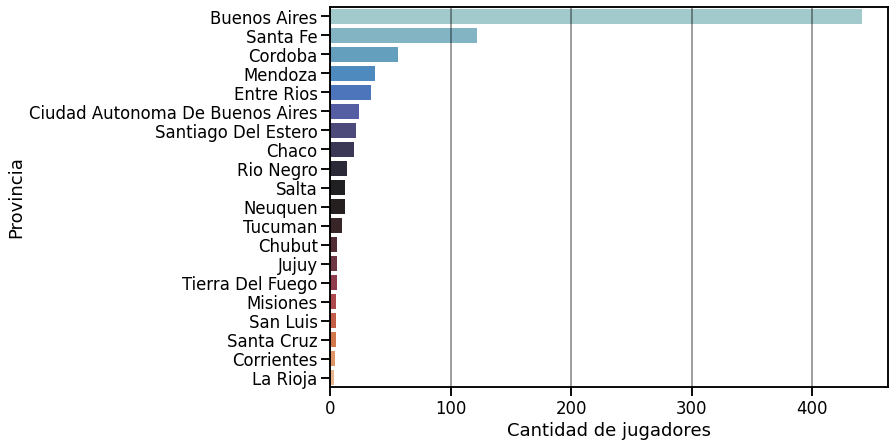

In [96]:
# armamos un grafico con los datos anteriores
fig = plt.figure(figsize=(10,7))

sns.barplot(y = data_arg.index[:20], x = data_arg.values[:20], palette = "icefire")

plt.ylabel('Provincia')
plt.xlabel('Cantidad de jugadores')
plt.grid(color = 'black', alpha = 0.5, axis='x')

### Jugadores de Venezuela agrupados por region

In [97]:
data_vnz = (df_drop[df_drop.country == 'Venezuela']
            .groupby('state')
            .id
            .nunique()
            .sort_values(ascending = False))
data_vnz

state
Zulia               103
Distrito Capital     89
Miranda              46
Carabobo             40
Aragua               39
Anzoategui           36
Monagas              29
Lara                 21
Merida               18
Yaracuy              13
Falcon               13
Tachira              12
La Guaira            12
Sucre                10
Guarico               8
Bolivar               6
Trujillo              5
Nueva Esparta         4
Barinas               4
Apure                 4
Cojedes               2
Portuguesa            2
Amazonas              1
Name: id, dtype: int64

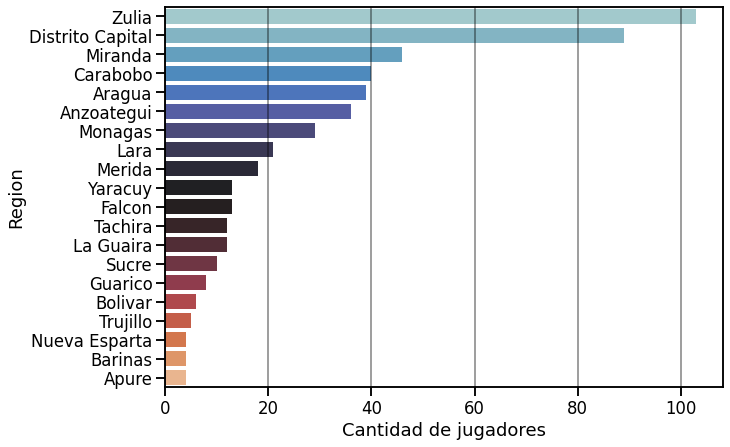

In [98]:
# armamos un grafico con los datos anteriores
fig = plt.figure(figsize=(10,7))

sns.barplot(y = data_vnz.index[:20], x = data_vnz.values[:20], palette='icefire')

plt.ylabel('Region')
plt.xlabel('Cantidad de jugadores')
plt.grid(color = 'black', alpha = 0.5, axis='x')

##### Sección 4: Reorganización del dataset
 1.Derivar distintas características de cada jugador, como ser la cantidad máxima de copas ganadas, la
cantidad de registros de cada uno, edad, etc.<br>
 2.Hacer un nuevo dataset donde cada jugador aparezca una vez, junto a sus distintas características derivadas
de los datos crudos.<br>

##### Observaciones por jugador

In [99]:
entries_df = pd.DataFrame(df_drop.id.value_counts()).reset_index()
entries_df.columns = ['id', 'entries']
entries_df

,id,entries
0,ARG-34,15746
1,ARG-68,15673
2,ARG-89,15505
3,ARG-58,15486
4,ARG-81,15287
...,...,...
1409,VEN-326,3
1410,ARG-597,2
1411,ARG-452,1
1412,ARG-593,1


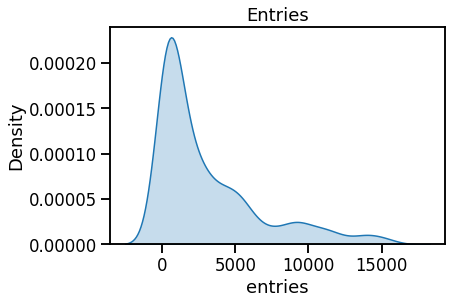

In [100]:
# visualizamos la distribucion observaciones por jugador
sns.kdeplot(data = entries_df, x = 'entries',
           fill = True)
plt.title('Entries')
plt.show()

##### Maxima cantidad de copas por jugador


In [101]:
max_cups_df = pd.DataFrame(df_drop.groupby('id')
                       .cups
                       .max()
                       ).reset_index()
max_cups_df

,id,cups
0,ARG-1,1784
1,ARG-10,1312
2,ARG-100,1680
3,ARG-101,1267
4,ARG-102,1823
...,...,...
1409,VEN-95,1983
1410,VEN-96,1549
1411,VEN-97,1502
1412,VEN-98,1705


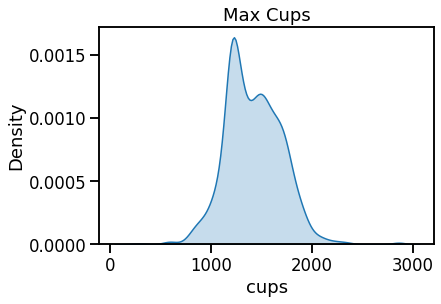

In [102]:
# visualizamos el maximo numero de copas gandas por jugador
sns.kdeplot(data = max_cups_df, x = 'cups',
           fill = True)
plt.title('Max Cups')
plt.show()

##### Edad de cada jugdor

In [103]:
birth_df = pd.DataFrame(df_drop.groupby('id')
                     .birth
                     .mean()                     
                    ).reset_index()
birth_df['age'] = (2022 - birth_df['birth'])
birth_df

,id,birth,age
0,ARG-1,"1,997.00",25.00
1,ARG-10,"1,996.00",26.00
2,ARG-100,"1,998.00",24.00
3,ARG-101,"1,997.00",25.00
4,ARG-102,"2,002.00",20.00
...,...,...,...
1409,VEN-95,"1,993.00",29.00
1410,VEN-96,"2,003.00",19.00
1411,VEN-97,"2,001.00",21.00
1412,VEN-98,"1,993.00",29.00


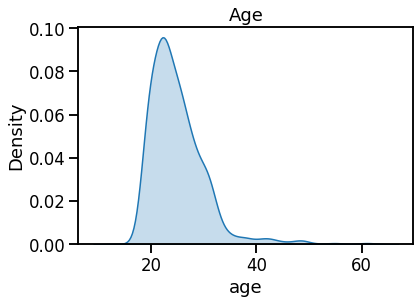

In [104]:
# visualizamos la distribucion de edades de los jugadores
sns.kdeplot(data = birth_df, x = 'age',
           fill = True)

plt.title('Age')
plt.show()

---

In [105]:
# creamos una nueva columna que tiene date_time y cups en la misma celda guardados en forma de tupla.
df_drop['day_cups'] = list(zip(df_drop.datetime, df_drop.cups))

In [106]:
df.shape

(4404492, 8)

In [119]:
df_new = df_drop[['id','day_cups']]
df_new

,id,day_cups
0,ARG-1,"(2021-11-08 14:05:15, 1268)"
1,ARG-2,"(2021-11-08 14:05:16, 1212)"
2,ARG-3,"(2021-11-08 14:05:16, 1343)"
3,VEN-1,"(2021-11-08 14:05:16, 1237)"
4,VEN-2,"(2021-11-08 14:05:16, 1191)"
...,...,...
4404487,ARG-401,"(2022-04-18 13:14:50, 1199)"
4404488,ARG-27,"(2022-04-18 13:14:52, 1472)"
4404489,VEN-349,"(2022-04-18 13:15:10, 1057)"
4404490,ARG-791,"(2022-04-18 13:15:14, 998)"


In [120]:
# esta linea tarda un poco en correr, pero no tarda mas de 10 minutos
# concatenamos en una misma celda los datos de FECHA y NUMERO DE COPAS para cada jugador
df_group_by = pd.DataFrame(df_new.groupby('id').sum('day_cups'))

In [121]:
df_2 = df_group_by.copy()
df_2.reset_index(inplace=True)
df_2

,id
0,ARG-1
1,ARG-10
2,ARG-100
3,ARG-101
4,ARG-102
...,...
1409,VEN-95
1410,VEN-96
1411,VEN-97
1412,VEN-98


In [110]:
df_2.shape

(1414, 1)

In [112]:
def split_tuple(tupla):
# toma una tupla y la splitea en una lista de tuplas de manera tal que 
# el resultado final es [(fecha, cups),(fecha, cups),...(fecha, cups)]
    
    splited_tuple = []
    for i in range(0,len(tupla),2):
        splited_tuple.append((tupla[i:i+2]))
    return splited_tuple

df_2["day_cups"] = df_2['day_cups'].apply(split_tuple)

KeyError: 'day_cups'

De esta manera lo que conseguimos es no perder la "historia de cada jugador", de manera tal que en la columna 'day_cups' nos queda asentado, para cada fecha que cantidad de copas tenia el jugador en formato de una lista de tuplas.

In [ ]:
df_2

In [ ]:
df_drop_2 = df_drop[['id','has_studies','gender', 'country', 'state']]
df_drop_2.drop_duplicates(inplace = True)
df_drop_2.reset_index(inplace = True, drop =True )
df_drop_2

In [ ]:
# para hacer los merge
df_3 = pd.merge(df_drop_2, entries_df, on = 'id')
df_4 = pd.merge(df_3, birth_df, on = 'id')
df_5 = pd.merge(df_4, max_cups_df, on = 'id')
df_final = pd.merge(df_5, df_2, on = 'id')
df_final

In [ ]:
# el objetivo de esta celda es obtener una visualizacion de la historia de cada jugador
# cambiando el indice 
fig = plt.figure(figsize = (14,7))

# Remove ticks and labels on x-axis and y-axis both
# Si no sacamos los labels del eje x, tarda mucho en correr.
ax = plt.gca()
ax.axes.xaxis.set_ticks([])

#definimos que jugador queremos analizar.
player = 232
data_new = df_final.day_cups[player]


sns.lineplot(data = data_new,
             x = [x[0] for x in data_new],
             y = [x[1] for x in data_new])

ax.set_ylim([-100, 3000])
plt.show()

# para mejorar el grafico faltaria agregar la fecha de inicio y fecha de final en el eje x del grafico